In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor
from scipy.stats import spearmanr

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE

import scanpy as sc

from config import FDIR_EXTERNAL, FDIR_RAW, FDIR_PROCESSED, FDIR_INTEMEDIATE


#! OUTDATED CODE, SE AgePredictionRNASeq.ipynb

In [2]:
transcripts = {
    "HEART": {
        "male": [],
        "female": []
    }, 
    "BRAIN0": {
        "male": [],
        "female": []
    }, 
    "BRAIN1": {
        "male": [],
        "female": []
    }, 
    'CAGE.HEART': {
        'male': [],
        'female': []
    }
}

In [3]:
fdir_raw = FDIR_RAW
fdir_intermediate = FDIR_INTEMEDIATE
fdir_processed = FDIR_PROCESSED / 'sex'
fdir_external = FDIR_EXTERNAL

ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
# organ = "BRAIN1"
# organ = 'CAGE.HEART'

# 
sex = 'male'
sex = 'female'

n_opt_features = {
    "HEART": {
        "male": 9,
        "female": 11
    }, 
    "BRAIN0": {
        "male": 7,
        "female": 7
    }, 
    "BRAIN1": {
        "male": 17,
        "female": 8
    }, 
}

# transcripts[organ] = {}
# transcripts[organ][sex] = []


In [46]:
import anndata as ad

# adata = ad.read_h5ad(fdir_processed / f'{organ.upper()}.preprocessed.sex.h5ad')
adata = ad.read_h5ad(fdir_intermediate/f'{organ.upper()}.raw.h5ad')


adata.obs['age'] = adata.obs['Age']

adata = adata[adata.obs['age'].notna()]

# # if organ == "BRAIN1":
# #     data_header['sex'] = data_header['gender'] 

adata_male = adata[adata.obs['sex'] == "male"]
adata_female = adata[adata.obs['sex'] == "female"]
adata_both = adata.copy()


In [47]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

for i in tqdm(range(adata_male.n_vars)):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
# for i in tqdm(range(adata_female.n_vars)):
    rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

rhos_male_nonan_ids = np.argwhere(~np.isnan(rhos_male)).ravel()
rhos_female_nonan_ids = np.argwhere(~np.isnan(rhos_female)).ravel()

  0%|          | 0/377460 [00:00<?, ?it/s]/tmp/ipykernel_182148/2705881400.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
/tmp/ipykernel_182148/2705881400.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
100%|██████████| 377460/377460 [23:59<00:00, 262.29it/s]


In [49]:
adata_male.varm['rho'] = rhos_male
adata_female.varm['rho'] = rhos_female

adata_male.varm['pvalue'] = np.array(pvalues_male)
adata_female.varm['pvalue'] = np.array(pvalues_female)

adata_male_nona = adata_male[:, rhos_male_nonan_ids]
adata_female_nona = adata_female[:, rhos_female_nonan_ids]

# rhos_female_nonan_ids
# adata_male
adata_female_nona

View of AnnData object with n_obs × n_vars = 11 × 221224
    obs: 'Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cardiac_chamber', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'health_state', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sex', 'source_name', 'SRA Study', 'tissue', 'age'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    varm: 'rho', 'pvalue'

In [50]:
diff_corr_ids_sorted = np.argsort((adata_male_nona.varm['rho'] - adata_female_nona.varm['rho'])**2)[::-1]

index=1

print((adata_male_nona.varm['rho'] - adata_female_nona.varm['rho'])[diff_corr_ids_sorted[index]])
print(adata_male_nona.varm['pvalue'][diff_corr_ids_sorted[index]])
print(adata_female_nona.varm['pvalue'][diff_corr_ids_sorted[index]])


ValueError: operands could not be broadcast together with shapes (209224,) (221224,) 

In [51]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

adata_eval = ad.read_h5ad(fdir_processed / f'{organ.upper()}.preprocessed.sex.h5ad')
adata_eval.obs['age'] = adata_eval.obs['Age']

adata_eval = adata_eval[adata_eval.obs['age'].notna()]

adata_eval.var_names = "tr_" + adata_eval.var_names
adata.var_names = "tr_" + adata.var_names


In [52]:
common_transcripts = adata.var_names.intersection(adata_eval.var_names)

data_eval = adata_eval[:, common_transcripts]
data = adata[:, common_transcripts]

In [53]:
# data.obs['age']

In [54]:
rhos = []
pvalues = []

y = data.obs[value_to_predict.lower()]
X = data.X

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)

reject, pvalues_corrected, sidac, bonf = multipletests(pvalues, alpha=0.05, method='fdr_bh')
np.argwhere(reject), np.argwhere(np.array(pvalues) < 0.05)

100%|██████████| 28445/28445 [00:28<00:00, 998.85it/s] 


NameError: name 'multipletests' is not defined

In [56]:
adata = data.copy()

rhos_nonan_ids = np.argwhere(~np.isnan(rhos)).flatten()

adata.varm['rho'] = np.array(rhos)
adata.varm['pvalue'] = np.array(pvalues)

adata = adata[:, rhos_nonan_ids]
adata

View of AnnData object with n_obs × n_vars = 20 × 28445
    obs: 'Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cardiac_chamber', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'health_state', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sex', 'source_name', 'SRA Study', 'tissue', 'age'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    varm: 'rho', 'pvalue'

In [57]:
# np.argwhere(np.array(pvalues) < 0.05).shape

# unsignificant_corr_ids = np.argwhere(np.array(pvalues_corrected) > 0.05)
unsignificant_corr_ids = np.argwhere(adata.varm['pvalue'] > 0.05)

# unsignificant_corr_ids

rhos = np.array(adata.varm['rho'])
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0

# adata.varm['rho'] = rhos

### Select by correlation value

In [58]:
# Select by correlation value

corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.4

if np.abs(rhos).max() > corr_threshold:
    
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []
sorted_corr_ids, sorted_corr_ids.shape

(array([ 4835,  8724, 20367, ...,  6902, 16752,   165]), (1952,))

In [59]:
adata.varm['rho'][sorted_corr_ids].shape

(1952,)

### Select by feature importance 

In [ ]:
# # select by feature importance
# model = XGBRegressor(n_estimators=300, max_depth=4, )

# X = data.values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

# # model.fit(RobustScaler().fit_transform(X),  y)
# model.fit(X,  y)
# importances = model.feature_importances_

# sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

### Select by Scanpy variance

In [ ]:
# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")

gtf_data

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
ENST00000003912.7,chr1,StringTie,transcript,24415803,24473468,1000.0,+,0,MSTRG.676,,NIPAL3,ENSG00000001461.17,ENST00000003912.7
ENST00000004103.8,chr7,StringTie,transcript,150800769,150806496,1000.0,+,0,MSTRG.32371,,TMEM176A,ENSG00000002933.9,ENST00000004103.8
ENST00000005340.10,chr17,StringTie,transcript,7225342,7234732,1000.0,-,0,MSTRG.14242,,DVL2,ENSG00000004975.12,ENST00000005340.10
ENST00000006658.11,chr17,StringTie,transcript,50547174,50555852,1000.0,+,0,MSTRG.15427,,SPATA20,ENSG00000006282.22,ENST00000006658.11
ENST00000011473.6,chr7,StringTie,transcript,106090505,106112589,1000.0,-,0,MSTRG.31874,,SYPL1,ENSG00000008282.10,ENST00000011473.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSTRG.9948.7,chr14,StringTie,transcript,24439782,24442905,1000.0,-,0,MSTRG.9948,,,,MSTRG.9948.7
MSTRG.9968.1,chr14,StringTie,transcript,30622137,30737694,1000.0,+,0,MSTRG.9968,,,,MSTRG.9968.1
MSTRG.9975.19,chr14,StringTie,transcript,31561457,31861290,1000.0,+,0,MSTRG.9975,,,,MSTRG.9975.19
MSTRG.9996.5,chr14,StringTie,transcript,30880617,30886923,1000.0,-,0,MSTRG.9996,,,,MSTRG.9996.5


In [ ]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(data)
adata.var = gtf_data
adata.obs = data_header



In [ ]:
# disease_state
adata.obs[['DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'disease_state', 'Experiment',
       'gender', 'Instrument', 'Library Name', 'library_size', 'LibraryLayout',
       'LibrarySelection', 'LibrarySource', 'manner_of_death', 'Organism',
       'patients_ID', 'PH', 'Platform', 'pmi', 'RACE', 'ReleaseDate',]]

,DATASTORE filetype,DATASTORE provider,DATASTORE region,disease_state,Experiment,gender,Instrument,Library Name,library_size,LibraryLayout,LibrarySelection,LibrarySource,manner_of_death,Organism,patients_ID,PH,Platform,pmi,RACE,ReleaseDate
SRR19147434,"run.zq,sra,fastq","ncbi,gs,s3","ncbi.public,gs.US,s3.us-east-1",psychosis_schizophrenia,SRX15214383,female,NextSeq 500,GSM6123999,37391426,PAIRED,cDNA,TRANSCRIPTOMIC,Suicide,Homo sapiens,843,7.1,ILLUMINA,17.1,White,2022-08-31T00:00:00Z
SRR19147435,"fastq,sra,run.zq","ncbi,s3,gs","s3.us-east-1,gs.US,ncbi.public",match control,SRX15214382,male,NextSeq 500,GSM6123998,32401058,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,822,7.2,ILLUMINA,25.1,Black,2022-08-31T00:00:00Z
SRR19147436,"fastq,run.zq,sra","ncbi,gs,s3","gs.US,s3.us-east-1,ncbi.public",psychosis_schizophrenia,SRX15214381,male,NextSeq 500,GSM6123997,30529401,PAIRED,cDNA,TRANSCRIPTOMIC,Suicide,Homo sapiens,787,6.9,ILLUMINA,19.1,Black,2022-08-31T00:00:00Z
SRR19147437,"run.zq,fastq,sra","gs,ncbi,s3","ncbi.public,gs.US,s3.us-east-1",psychosis_schizophrenia,SRX15214384,male,NextSeq 500,GSM6124000,34023545,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,878,6.9,ILLUMINA,11.2,White,2022-08-31T00:00:00Z
SRR19147438,"sra,run.zq,fastq","s3,gs,ncbi","gs.US,ncbi.public,s3.us-east-1",match control,SRX15214380,male,NextSeq 500,GSM6123996,30515047,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,739,6.7,ILLUMINA,15.8,White,2022-08-31T00:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147622,"fastq,run.zq,sra","s3,gs,ncbi","gs.US,s3.us-east-1,ncbi.public",match control,SRX15214196,male,NextSeq 500,GSM6123963,33613429,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,13069,6.8,ILLUMINA,25.8,White,2022-08-31T00:00:00Z
SRR19147623,"fastq,run.zq,sra","gs,s3,ncbi","ncbi.public,s3.us-east-1,gs.US",match control,SRX15214195,male,NextSeq 500,GSM6123962,34675663,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,13068,6.8,ILLUMINA,12.8,White,2022-08-31T00:00:00Z
SRR19147624,"fastq,sra,run.zq","gs,s3,ncbi","gs.US,ncbi.public,s3.us-east-1",psychosis_schizophrenia,SRX15214194,female,NextSeq 500,GSM6123961,39553995,PAIRED,cDNA,TRANSCRIPTOMIC,Undetermined,Homo sapiens,13045,6.3,ILLUMINA,8.3,White,2022-08-31T00:00:00Z
SRR19147625,"sra,fastq,run.zq","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.US",psychosis_schizophrenia,SRX15214192,male,NextSeq 500,GSM6123959,37580048,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,13017,6.6,ILLUMINA,25.3,White,2022-08-31T00:00:00Z


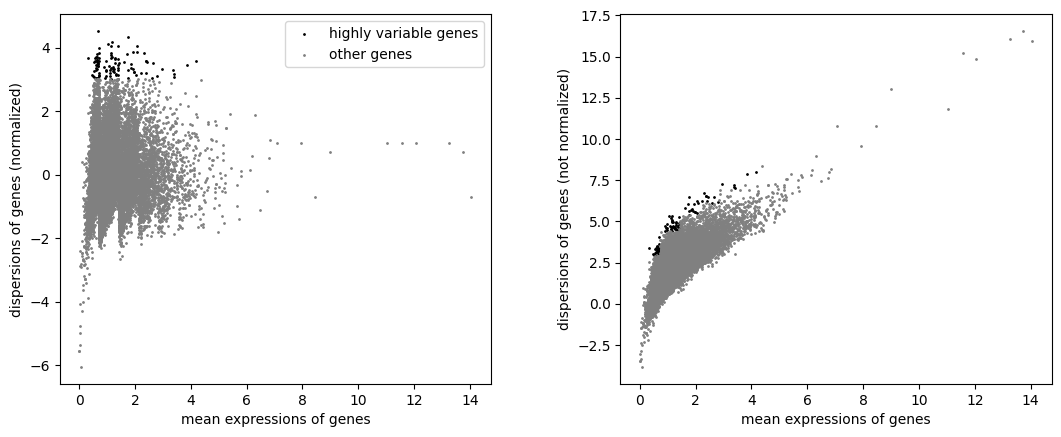

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='seurat')
sc.pl.highly_variable_genes(adata)


In [ ]:
corr_ids = np.argwhere(adata.var['highly_variable']).ravel()
# corr_ids
sorted_corr_ids = corr_ids[np.argsort(adata[:, corr_ids].var['highly_variable_rank'].values)[::-1]]
adata[:, sorted_corr_ids].var

KeyError: 'highly_variable_rank'

# EVALUATE

In [60]:
adata[:, sorted_corr_ids]

View of AnnData object with n_obs × n_vars = 20 × 1952
    obs: 'Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cardiac_chamber', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'health_state', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sex', 'source_name', 'SRA Study', 'tissue', 'age'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    varm: 'rho', 'pvalue'

In [61]:
adata_female_nona.varm['rho']

ArrayView([ 0.25808091, -0.23418453,  0.06213059, ..., -0.36800426,
            0.15771611,  0.42215566])

/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


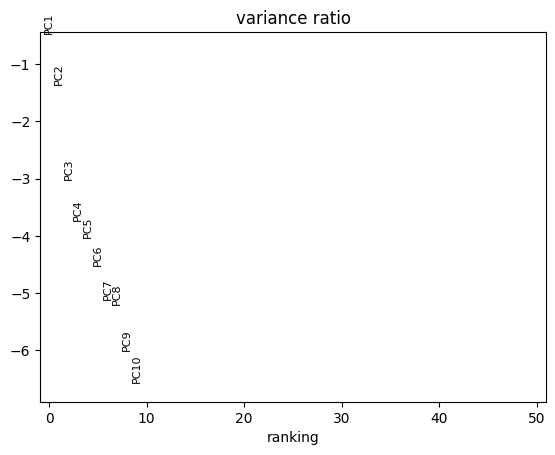

In [62]:
sc.tl.pca(adata_female_nona)
sc.pl.pca_variance_ratio(adata_female_nona, n_pcs=50, log=True)

In [63]:
adata_female_nona.varm['PCs'].shape, adata_female_nona.obsm['X_pca'].shape

((221224, 10), (11, 10))

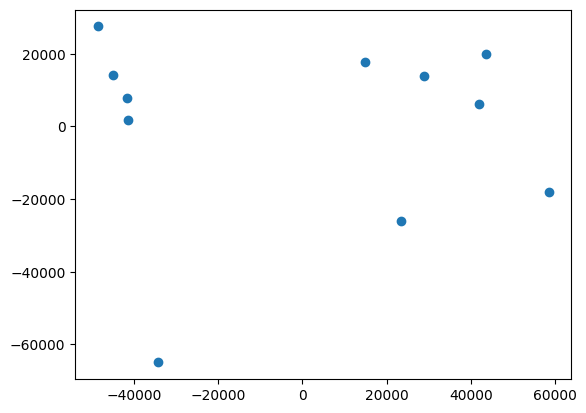

In [64]:
from sklearn.decomposition import PCA

pca = PCA(None)
X_trainsformed = pca.fit_transform(adata_female_nona.X)
plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
# plt.plot(adata_female.obs['age'], X_trainsformed[:,3], 'o')
# plt.plot(data_header_both['Age'], X_trainsformed[:,0], 'o')

In [65]:
adata.var.iloc[sorted_corr_ids], len(sorted_corr_ids) 

(                      seqname     source     feature      start        end  \
 tr_ENST00000426161.8     chr1  StringTie  transcript  212856604  212858139   
 tr_ENST00000508608.6     chr5  StringTie  transcript   96663025   96773267   
 tr_MSTRG.17989.3        chr19  StringTie  transcript   41454169   41501255   
 tr_MSTRG.5258.13        chr11  StringTie  transcript     827298     831991   
 tr_MSTRG.29444.5         chr6  StringTie  transcript   32517352   32589848   
 ...                       ...        ...         ...        ...        ...   
 tr_MSTRG.28377.4         chr5  StringTie  transcript  142000515  142013051   
 tr_ENST00000580724.1    chr17  StringTie  transcript   75605867   75607130   
 tr_ENST00000473837.5     chr9  StringTie  transcript  125505944  125650461   
 tr_ENST00000691039.2    chr17  StringTie  transcript   47488559   47492623   
 tr_ENST00000228928.12   chr12  StringTie  transcript  112938474  112976460   
 
                         score strand  frame      

In [67]:
sex = "female"
# adata[adata.obs['sex'] == sex]
adata[adata.obs['sex'] == sex, adata.var.iloc[sorted_corr_ids].index[0]].X.ravel()

ArrayView([0.548649, 1.849611, 1.338867, 0.580425, 1.271193, 2.276487,
           1.901084, 0.      , 0.      , 0.      , 0.      ],
          dtype=float32)

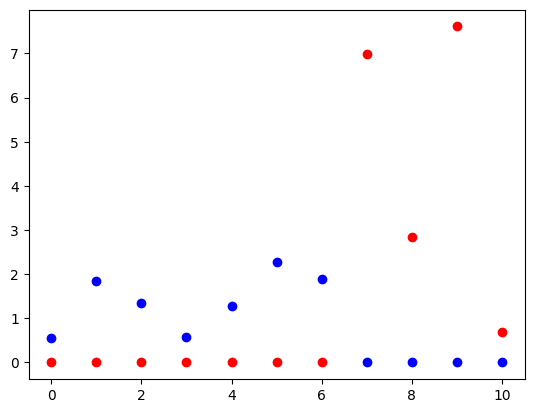

In [68]:
plt.plot(adata[adata.obs['sex'] == sex, adata.var.iloc[sorted_corr_ids].index[0]].X.ravel(), 'bo')
plt.plot(adata[adata.obs['sex'] == sex, adata.var.iloc[sorted_corr_ids].index[1]].X.ravel(), 'ro')

In [69]:

# HEART_eval_df = pd.DataFrame.from_dict(HEART_eval)
# BRAIN0_eval_df = pd.DataFrame.from_dict(BRAIN0_eval)
# BRAIN1_eval_df = pd.DataFrame.from_dict(BRAIN1_eval)


HEART_eval_df = pd.DataFrame.from_dict(eval_dict['HEART'])
# BRAIN0_eval_df = pd.DataFrame.from_dict(eval_dict['BRAIN0'])
# BRAIN1_eval_df = pd.DataFrame.from_dict(eval_dict['BRAIN1'])
# BRAIN1_eval_df

NameError: name 'eval_dict' is not defined

In [70]:
adata.obs['sex'] == 'male'

SRR21423854    False
SRR21423855    False
SRR21423856    False
SRR21423857    False
SRR21423858    False
SRR21423859    False
SRR21423860    False
SRR21423861    False
SRR21423862    False
SRR21423863    False
SRR21423864    False
SRR21423865     True
SRR21423866     True
SRR21423867     True
SRR21423868     True
SRR21423869     True
SRR21423870     True
SRR21423871     True
SRR21423872     True
SRR21423873     True
Name: sex, dtype: bool

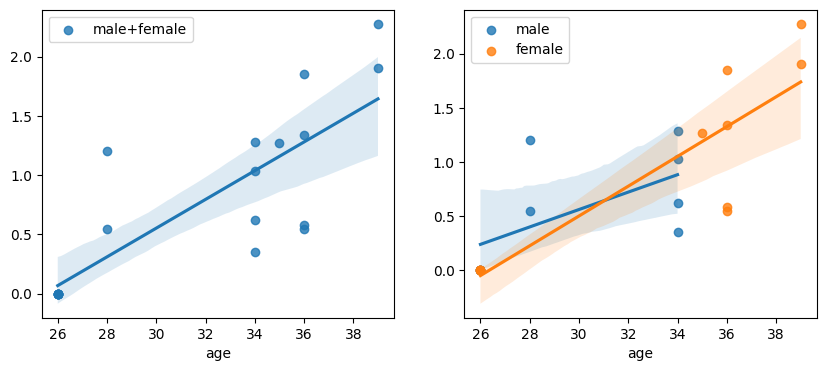

In [73]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=adata.X[:, sorted_corr_ids[0]], x=adata.obs['age'], ax=axs[0], label='male+female')
sns.regplot(y=adata.X[:, sorted_corr_ids[0]][adata.obs['sex'] == 'male'], 
            x=adata.obs['age'][adata.obs['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=adata.X[:, sorted_corr_ids[0]][adata.obs['sex'] == 'female'], 
            x=adata.obs['age'][adata.obs['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [75]:
from sklearn.preprocessing import PolynomialFeatures


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([adata.n_vars+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [2]:

    X = adata[:, sorted_corr_ids[:n_features]].X
    # y = data_header['Age'].loc[data_header['sex'] == sex].values
    y = adata.obs['age'].values
    # y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values

    
    # print(X.shape)
    print(f"{n_features=}")
    
    cv = StratifiedKFold(n_splits=5)
    # cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values

        # poly = PolynomialFeatures(degree=2)
        # X_train_ = poly.fit_transform(X_train_)
        # X_val = poly.transform(X_val)
        
        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        # # print(f"{X_train_.shape=}")
        # # print(f"{X_val.shape=}")
        # epsilon = 1e-4
        # lam = 0.1
        # iterations = 50
        # random_restarts = 20
        # model = LinearRegressionsMixture(X_train_, np.expand_dims(y_train_, axis=1), K=2)
        # model.train(epsilon=epsilon, lam=lam, iterations=iterations, random_restarts=random_restarts, verbose=False)
        # pred = [model.predict(X_val[i]) for i in range(X_val.shape[0])]

        preds.extend(pred)
        vals.extend(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLM(y_train_, X_train_,
        #              family=sm.families.NegativeBinomial()).fit()
        
        # gls_pred = mod.predict(X_test)
        # gls_preds.extend(gls_pred)
        

    print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
    print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
    # print("GLM RMSE: ", RMSE(gls_preds, vals))
    # print("GLM R2: ", r2_score(vals, gls_preds))
    
    # print("GLM RMSE: ", np.mean(rmses))
    # print("GLM R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

20
n_features=1


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 489.49it/s]


RMSE:  3.0908863439417136
R2:  0.5908093632652158
--------------------
n_features=2


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1061.37it/s]


RMSE:  3.025709887413825
R2:  0.6078843421011336
--------------------
n_features=3


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1321.54it/s]


RMSE:  1.9616845842946427
R2:  0.8351769393614201
--------------------
n_features=4


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1147.30it/s]


RMSE:  1.979102318114729
R2:  0.8322370281371841
--------------------
n_features=5


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1146.42it/s]


RMSE:  2.0698307488086747
R2:  0.8165028663148568
--------------------
n_features=6


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 791.95it/s]


RMSE:  1.4611548465501145
R2:  0.9085566555050053
--------------------
n_features=7


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 948.51it/s]


RMSE:  1.6900669684089002
R2:  0.8776602909216469
--------------------
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 567.26it/s]


RMSE:  1.8009215909752603
R2:  0.8610849736870816
--------------------
n_features=9


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 964.47it/s]


RMSE:  1.9224798486152341
R2:  0.8416991640076388
--------------------
n_features=10


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1019.27it/s]


RMSE:  1.6937038223050296
R2:  0.8771331989424707
--------------------
n_features=11


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 946.07it/s]


RMSE:  1.743593712450327
R2:  0.8697882413921699
--------------------
n_features=12


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 931.78it/s]


RMSE:  2.200548880325143
R2:  0.7925938376828252
--------------------
n_features=13


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1099.54it/s]

RMSE:  2.1512357945741987
R2:  0.8017853969865174
--------------------


n_features=14


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1026.00it/s]


RMSE:  2.142793745145193
R2:  0.8033380432922856
--------------------
n_features=15


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 264.41it/s]


RMSE:  1.5123570553003438
R2:  0.9020355985558742
--------------------
n_features=16


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 268.97it/s]


RMSE:  1.65355222802392
R2:  0.8828896039917391
--------------------
n_features=17


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 309.08it/s]


RMSE:  1.575957522839127
R2:  0.8936227812916485
--------------------
n_features=18


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 296.07it/s]


RMSE:  1.7916063613852786
R2:  0.8625183272660372
--------------------
n_features=19


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 244.52it/s]

RMSE:  1.3402870637738085
R2:  0.9230594533325017
--------------------


array([[-0.39530466, -0.28595949, -1.80211973,  0.3064862 , -0.05777807,
        -0.61475142, -0.0347822 ,  0.15825481, -0.41055461, -0.26471504,
        -0.02313253,  0.12116172, -0.47016217,  0.05516721,  0.03745418,
        -0.07145393, -0.6176767 , -0.18927051,  0.2757336 ]])

In [81]:
# data[:, ]sorted_corr_ids
# sorted_corr_ids


,tr_ENST00000005082.13,tr_ENST00000005286.8,tr_ENST00000006750.8,tr_ENST00000007699.10,tr_ENST00000007722.11,tr_ENST00000008180.13,tr_ENST00000008938.5,tr_ENST00000011473.6,tr_ENST00000011653.9,tr_ENST00000011700.10,...,tr_MSTRG.9922.3,tr_MSTRG.9929.25,tr_MSTRG.9929.3,tr_MSTRG.994.1,tr_MSTRG.994.8,tr_MSTRG.9947.1,tr_MSTRG.9948.26,tr_MSTRG.9968.1,tr_MSTRG.9981.7,tr_MSTRG.9997.4
SRR21423854,0.156691,1.346087,1.537780,0.246084,0.214539,0.000000,0.002889,5.516233,6.519403,0.045520,...,0.000000,0.823095,1.480195,0.097675,0.000000,0.573413,1.895326,0.489953,0.288783,0.000000
SRR21423855,0.000000,2.432085,1.474957,0.056082,0.367119,1.409761,0.000000,0.000000,2.983190,0.352309,...,0.000000,0.139611,2.640031,0.000000,1.539203,0.119770,1.393650,0.000000,0.000000,0.000000
SRR21423856,0.000000,1.649931,4.249820,1.970781,0.000000,0.382776,0.000000,16.454346,12.715440,0.094379,...,0.000000,0.074038,0.075076,0.204225,0.033494,2.701091,1.044219,0.000000,10.087957,0.557652
SRR21423857,0.525308,3.444182,3.852285,1.912546,0.303771,0.913922,0.000000,4.339753,14.269823,0.620491,...,0.000000,0.062825,0.106465,0.534419,0.000000,0.069670,3.636693,0.032368,13.555885,0.000000
SRR21423858,0.389441,0.000000,0.000000,2.199364,0.590542,1.596131,0.000000,8.918693,12.714874,6.932531,...,0.000000,0.000000,4.772456,0.000000,0.000000,0.774729,2.086834,1.482764,9.991393,0.000000
SRR21423859,0.000000,0.632028,3.528450,1.254411,0.420689,0.527832,0.000000,0.166720,5.750813,0.000000,...,1.294378,0.444508,0.286908,0.000000,2.299511,0.324673,0.853203,3.686628,6.996751,0.000000
SRR21423860,0.269523,5.800220,4.833686,0.292843,0.742420,0.812710,0.000000,0.000000,5.158816,5.436779,...,0.000000,0.127139,0.142450,0.264500,0.000000,0.207586,2.782266,0.000000,6.992999,0.000000
SRR21423861,0.207238,1.681431,3.312181,0.000000,0.000000,0.075871,0.000000,5.343765,2.241142,0.000000,...,0.000000,0.662027,0.000000,0.000000,0.506821,0.099253,2.690979,0.000149,9.892489,0.000000
SRR21423862,0.393480,1.575399,2.820927,0.000000,1.125340,0.210151,0.000000,0.000000,4.015709,0.069264,...,0.000000,0.385933,0.000000,0.294640,0.878007,8.966240,0.958517,2.750154,0.000000,0.000000
SRR21423863,0.000000,0.028382,0.000000,0.451803,0.387156,0.137142,0.165696,0.886604,2.751691,0.239235,...,0.000000,0.093082,0.257356,0.326707,0.385807,0.405871,0.000000,0.000000,15.585952,0.000000


20
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1035.99it/s]

RMSE:  1.8009215909752603
MAE:  1.402705079357443
R2:  0.8610849736870816


array([[ 0.71034726, -0.62979818, -1.90291406,  0.91139569,  0.07195234,
        -0.69949832, -0.04209884,  0.36371445]])

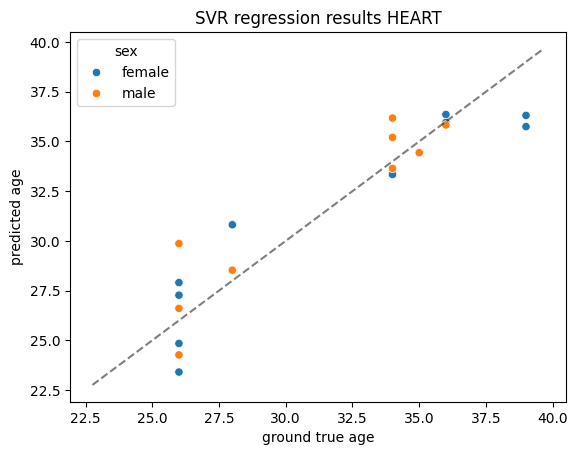

In [85]:
# n_features = 5
# n_features = -1

# sex = 'male'
print(data.shape[0])

# n_features = n_opt_features[organ][sex]
n_features = 8

# X = data.to_df()[data.to_df().columns[sorted_corr_ids[:n_features]]].values
# # y = data_header['Age'].loc[data_header['sex'] == sex].values
# y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values


X = adata[:, sorted_corr_ids[:n_features]].X
# y = data_header['Age'].loc[data_header['sex'] == sex].values
y = adata.obs['age'].values
# y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values

diagnosis = adata.obs['sex'] #.loc[data_header['sex'] == sex]
# print(X.shape)
print(f"{n_features=}")



cv = StratifiedKFold(n_splits=5)
# cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

rmses = []
maes = []
r2s = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    
    X_val = X_test
    y_val = y_test
    
    model = svm.SVR(kernel='linear')
    # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
    # model = LinearRegression()
    # model = Ridge()
    # model = XGBRegressor(n_estimators=300, max_depth=4, )
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    model.fit(X_train_, y_train_)
    
    
    # X_train_ = sm.add_constant(X_train_)
    # X_test = sm.add_constant(X_test, has_constant='add')
    
    # mod = sm.GLM(y_train_, X_train_,
    #                 family=sm.families.NegativeBinomial()).fit()
    
    # gls_pred = mod.predict(X_test)
    # preds.append(gls_pred)
    
    pred = model.predict(X_val)
    preds.extend(pred)
    vals.extend(y_val)

print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
# print("RMSE: ", RMSE(gls_preds, vals))
print("MAE: ", MAE(np.ravel(preds), np.ravel(vals)))
print("R2: ", r2_score(vals, preds))

# model.coef_

colors = {
    'male': 'blue',
    "female": "orange"
}

g = sns.scatterplot(
    x=np.array(vals).ravel(), 
    y=np.array(preds).ravel(), 
    # color=colors[sex],
    hue=diagnosis
    )
g.set_title(f"SVR regression results {organ}")
g.set_ylabel("predicted age")
g.set_xlabel("ground true age")

lims = [
    np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
    np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
]


g.plot(lims, lims, '--', color='k', alpha=0.5)

# g.set_xlim(lims)
# g.set_ylim(lims)

# transcripts[organ][sex] = data.columns[sorted_corr_ids[:n_features]].tolist()
model.coef_


In [ ]:
data_header_both['Age'].loc[data_header_both['tissue'] != "Nac"]

SRR19147434    41
SRR19147435    28
SRR19147436    27
SRR19147437    33
SRR19147438    40
               ..
SRR19147622    53
SRR19147623    48
SRR19147624    29
SRR19147625    62
SRR19147626    48
Name: Age, Length: 144, dtype: int64

Text(37.722222222222214, 0.5, 'Age')

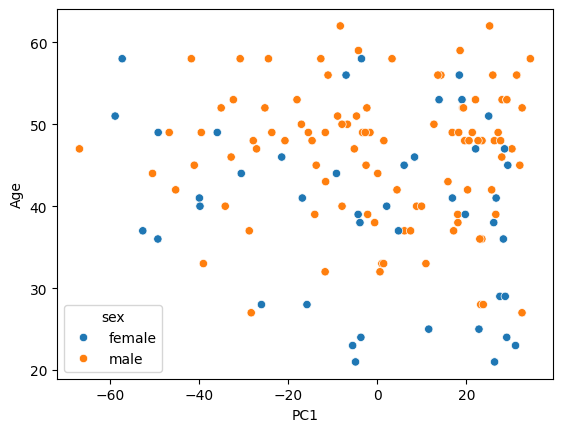

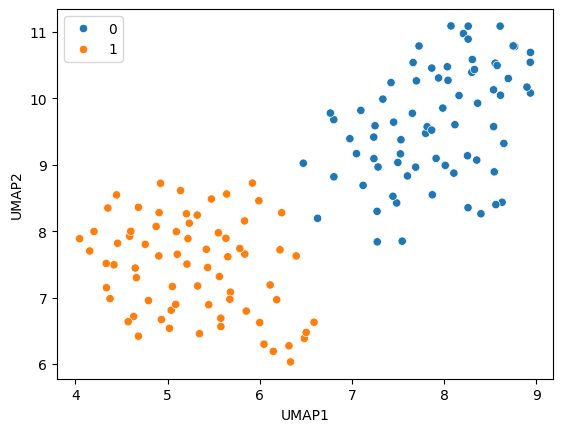

<Figure size 640x480 with 0 Axes>

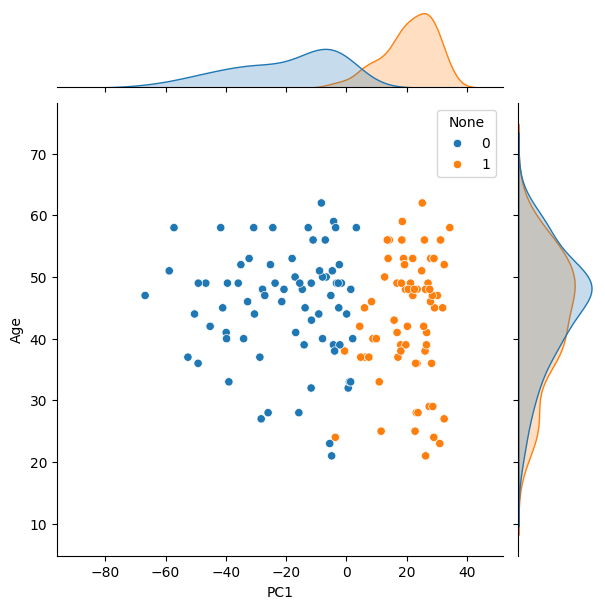

In [ ]:
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture


# Putamen | Caudate | Nac

n_features = 20

# X_ = data_both.values
# y_ = data_header_both['Age'].values

X_ = data.loc[data_header['tissue'] != "Nac"].values
y_ = data_header['Age'].loc[data_header['tissue'] != "Nac"].values
    
    
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_)
# sns.scatterplot(x=X_pca[:, 0], y=y_, hue=data_header_both['tissue'])
sns.scatterplot(x=X_pca[:, 0], y=y_, hue=data_header_both['sex'].loc[data_header_both['tissue'] != "Nac"])
# X_pca.shape
plt.xlabel("PC1")
plt.ylabel("Age")
# plt.figure()
# plt.plot(pca.explained_variance_ratio_)


reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_)

# clusterer = KMeans(n_clusters=2)
# clusterer = DBSCAN()
clusterer = GaussianMixture(n_components=2)

clusterer.fit(X_umap)
# labels = clusterer.labels_
labels = clusterer.predict(X_umap)

plt.figure()
# sns.scatterplot(x=X_pca[:, 0], y=y_, hue=data_header_both['tissue'])
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels)
# X_pca.shape
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# plt.figure()
# plt.plot(pca.explained_variance_ratio_)

plt.figure()
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_)
sns.jointplot(x=X_pca[:, 0], y=y_, hue=labels)
# sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels)
# X_pca.shape
plt.xlabel("PC1")
plt.ylabel("Age")
# plt.figure()
# plt.plot(pca.explained_variance_ratio_)

In [ ]:

from sklearn.preprocessing import PolynomialFeatures



print(data.shape[0])

# X_ = data_both.loc[data_header_both['tissue'] != "Nac"].values
# y_ = data_header_both['Age'].loc[data_header_both['tissue'] != "Nac"].values

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [2]:

    # X = data_both[data_both.columns[sorted_corr_ids[:n_features]]].values
    # # y = data_header['Age'].loc[data_header['sex'] == sex].values
    # y = data_header_both['Age'].loc[data_header_both['tissue'] != "Nac"].values
    
    X = data[data.columns[sorted_corr_ids[:n_features]]].loc[data_header['tissue'] != "Nac"].values
    y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values
    
    # X = data[data.columns[sorted_corr_ids[:n_features]]].values
    # # y = data_header['Age'].loc[data_header['sex'] == sex].values
    # y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values

    X = X[np.argwhere(labels == 1).ravel()]
    y = y[np.argwhere(labels == 1).ravel()]
    
    print(X.shape)
    print(f"{n_features=}")
    
    cv = StratifiedKFold(n_splits=5)
    # cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values

        # poly = PolynomialFeatures(degree=2)
        # X_train_ = poly.fit_transform(X_train_)
        # X_val = poly.transform(X_val)
        
        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        # # print(f"{X_train_.shape=}")
        # # print(f"{X_val.shape=}")
        # epsilon = 1e-4
        # lam = 0.1
        # iterations = 50
        # random_restarts = 20
        # model = LinearRegressionsMixture(X_train_, np.expand_dims(y_train_, axis=1), K=2)
        # model.train(epsilon=epsilon, lam=lam, iterations=iterations, random_restarts=random_restarts, verbose=False)
        # pred = [model.predict(X_val[i]) for i in range(X_val.shape[0])]

        preds.extend(pred)
        vals.extend(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLM(y_train_, X_train_,
        #              family=sm.families.NegativeBinomial()).fit()
        
        # gls_pred = mod.predict(X_test)
        # gls_preds.extend(gls_pred)
        

    print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
    print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
    # print("GLM RMSE: ", RMSE(gls_preds, vals))
    # print("GLM R2: ", r2_score(vals, gls_preds))
    
    # print("GLM RMSE: ", np.mean(rmses))
    # print("GLM R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

144
(71, 1)
n_features=1


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1295.98it/s]


RMSE:  9.127849116878709
R2:  0.1634716174473434
--------------------
(71, 2)
n_features=2


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1225.90it/s]


RMSE:  9.035494658658084
R2:  0.18031376404958155
--------------------
(71, 3)
n_features=3


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1144.42it/s]


RMSE:  8.813326317129754
R2:  0.22012773380194328
--------------------
(71, 4)
n_features=4


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1076.95it/s]


RMSE:  8.641487749021064
R2:  0.25024251052903634
--------------------
(71, 5)
n_features=5


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 459.92it/s]


RMSE:  8.43802165003779
R2:  0.2851333344953809
--------------------
(71, 6)
n_features=6


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1013.85it/s]


RMSE:  8.661401168775885
R2:  0.24678305108582943
--------------------
(71, 7)
n_features=7


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1081.28it/s]


RMSE:  8.552408500130026
R2:  0.26562032524147805
--------------------
(71, 8)
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1131.15it/s]


RMSE:  8.262841422437067
R2:  0.31450765147989357
--------------------
(71, 9)
n_features=9


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1020.71it/s]


RMSE:  8.343866432867525
R2:  0.30099792934054714
--------------------
(71, 10)
n_features=10


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1219.42it/s]


RMSE:  8.423253565870718
R2:  0.2876334400876315
--------------------
(71, 11)
n_features=11


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1135.68it/s]


RMSE:  8.392231724000748
R2:  0.2928709005889395
--------------------
(71, 12)
n_features=12


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1055.38it/s]


RMSE:  8.400229926000153
R2:  0.29152240196076495
--------------------
(71, 13)
n_features=13


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1089.09it/s]


RMSE:  7.8253694331459185
R2:  0.3851722305141686
--------------------
(71, 14)
n_features=14


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1000.50it/s]


RMSE:  7.977579861474638
R2:  0.3610217191895255
--------------------
(71, 15)
n_features=15


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 904.92it/s]


RMSE:  7.983309986821811
R2:  0.36010346060265774
--------------------
(71, 16)
n_features=16


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1021.41it/s]


RMSE:  8.079982364350249
R2:  0.34451221766174345
--------------------
(71, 17)
n_features=17


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1076.35it/s]


RMSE:  7.889792197452802
R2:  0.375007356890109
--------------------
(71, 18)
n_features=18


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1071.67it/s]


RMSE:  7.725788210393023
R2:  0.40072056783463794
--------------------
(71, 19)
n_features=19


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1096.72it/s]

RMSE:  7.751792936069433
R2:  0.3966794720738699
--------------------


array([[-0.10060605,  3.55268675, -1.9272347 ,  0.11950483,  2.48502955,
        -2.18541273,  0.95550403, -1.30300818, -1.17425371, -1.91722536,
         0.22259203, -0.02949038,  3.32648391, -0.08768893, -2.7035493 ,
         1.61489454,  1.60907133, -0.39253091, -1.06741569]])

In [ ]:
print(np.argsort(np.abs(pca.components_[0]))[::-1][:10])
print(pca.components_[0][np.argsort(np.abs(pca.components_[0]))[::-1][:10]])
print(data_both.columns[np.argsort(np.abs(pca.components_[0]))[::-1][:10]])

sns.stripplot(
    x=labels,
    # x=data_header_both['sex'].loc[data_header_both['tissue'] != "Nac"],
    # y=data_both.loc[data_header_both['tissue'] != "Nac"].iloc[:, np.argsort(np.abs(pca.components_[0]))[::-1][5]],
    y=data_both.loc[data_header_both['tissue'] != "Nac", 'ENST00000431584.2'],
    hue=data_header_both['sex'].loc[data_header_both['tissue'] != "Nac"]
)


In [ ]:
import anndata as ad
import scanpy as sc

# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")
# adata = ad.AnnData(data_both)
# adata.var = gtf_data
# adata.obs = data_header_both

adata = ad.AnnData(data_both.loc[data_header_both['tissue'] != "Nac"])
adata.var = gtf_data
adata.obs = data_header_both.loc[data_header_both['tissue'] != "Nac"]


In [ ]:
adata.obs.columns

In [ ]:
# adata.obs['disease_state']

sc.tl.pca(adata)

# sc.pl.pca(adata, color='disease_state')
sc.pl.pca(adata, color=['tissue', 'tissue', 'sex', 'sex'],
          dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
          ncols=2)
# source_name, tissue => batch effect
sc.pl.pca_variance_ratio(adata, n_pcs=5)


In [ ]:
adata.obs.columns

# adata.obs['Sample Name']

In [ ]:
sc.pl.pca(adata, 
          color=['Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject',
                 'BMI', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype',
                 'DATASTORE provider', 'DATASTORE region', 'disease_state',
                 'gender', 'Instrument', 'library_size', 'LibraryLayout',
                 'LibrarySelection', 'LibrarySource', 'manner_of_death', 'Organism',
                 'patients_ID', 'PH', 'Platform', 'pmi', 'RACE', 'ReleaseDate', 'RIN',
                 'version', 'Sequence_ID', 'source_name',
                 'SRA Study', 'tissue', 'tissuestoragetime', 'sex'],
          ncols=2)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['source_name', 'tissue', 'disease_state', 'sex'], ncols=2)

In [ ]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.5)
sc.pl.pca(adata, color=["leiden"])


In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", n_genes=10,
)

sc.get.rank_genes_groups_df(adata, group="0").head(5)
# sc.get.rank_genes_groups_df(adata, group="1").head(5)

In [ ]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="1").head(5)["names"]
sc.pl.pca(
    adata,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

In [ ]:
# import copy
# transcripts_dict = copy.deepcopy(transcripts)

# # for organ in ['BRAIN0', "HEART", "BRAIN1"]:
# #     for sex in ['female', 'male']:
# #         transcripts_dict[organ][sex] = [".".join(el.split(".")[:-1]) for el in transcripts_dict[organ][sex]]
# transcripts_dict


In [ ]:
# adata.obs['Age']
sns.scatterplot(y=adata.obs['Age'], x=adata.obsm['X_pca'][:, 0], hue=adata.obs['leiden'])

In [ ]:
adata

In [ ]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

In [ ]:

sex = ['male', 'female'][1]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1"]:
    # test_dict[organ] = set(transcripts_dict[organ][sex])
    test_dict[organ] = set(transcripts_dict[organ]['male']).union(set(transcripts_dict[organ]['female']))


plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('dataset')


print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])


In [ ]:
organ = ['BRAIN0', "HEART", "BRAIN1"][1]
test_dict = {}
for sex in ['male', 'female']:
    test_dict[sex] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

g.axes['main'].set_ylabel(organ)

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

reducer = PCA(n_components=4)

X_transformed = reducer.fit_transform(X)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], ax=axs[0])
sns.scatterplot(x=X_transformed[:, 2], y=X_transformed[:, 3], ax=axs[1])
# sns.scatterplot(x=X[:, 2], y=X[:, 3], ax=axs[1])
